# Prijenos stila zvuka pomoću difuzijskih modela

Prije pokretanja bilježnice, potrebno je instalirati potrebne pakete. Osim toga potrebno je inalirati u skup podataka koji se koristi za treniranje određenog stila. Sve upute se nalaže u README.md datoteci.

Ideja ovog projekta je replicirati rad ovaj rad [Music Style Transfer with Time-Varying Inversion of Diffusion Models](https://lsfhuihuiff.github.io/MusicTI/). Naš model se satoji od 2 dijela:
1. **Riffusion okosnica** - predtrenirani model stabilne difuzije koji generira isječke zvuka
2. **TVE (Time-Varying Endocer) modul** - koristi se za pamčenje stila u određenom trenutku

TVE module je samo srce ovog rada s obzirom da je to jedini modul kojega treniramo, kako posjedujemo samo nekoliko primjera stila, nema smisla dodatni trenirati cijeli model, stoga treniramo samo TVE modul.

![TVE](./images/tve.png)

TVE modul radi tako da prvo vremenski korak *t* ugradi u neki prostoj, mi ga ugradujemo tako da koristmo sinusne i kosinusne transformacije. Nakon toga, koristimo neuronsku mrezu kako bi prebacili ugradeni vektor u cetiri puta veci prostors te ga naposljetku vracamo u originalni prostor. Kao aktivacijusku funkciju koristimo SiLU funkciju koja je definirana kao:

$$ SiLU(x) = x \cdot\sigma(x) $$

Ugradenom broju *t* pribrajamo originalni ugradeni vektor texta. Taj vektor odgovara ugradnji teksta "*" u vektorski prostor koji zapravo u nasem slucaju ce predstavljati bilo koji stil. Tako pribrojeni vektori se normaliciraju po sloju kako bi se ucenje stabilizitalo, prolazi kroz sloj paznje i sloj medu paznje iz cega dobijemo konacni vektor stila u trenutku *t*.

Model okosnice mozemo prikazati pomocu slijedeceg dijagrama koji zapravo prikazuje ucenje modela i model stabilne difuzije.

![TVE](./images/train.png)

VAE se koristi za prebacivanje pocetne slike u i iz latentnog prostora, dok potom UNet model koristimo za postepeno odstranjivanje suma iz latentnog prostora. Za ugradivanje teksta koristi se predtrenirani model CLIP.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import torch
from PIL import Image
from torch import nn
from tqdm import tqdm

from models.style_transfer import SoundStyleTransferModel
from convert.transform import Transform
# from metrics import content_preservation, style_fit

In [2]:
model = SoundStyleTransferModel()

/home/fpankretic/miniconda3/envs/sound-transfer/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
An error occurred while trying to fetch riffusion/riffusion-model-v1: riffusion/riffusion-model-v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch riffusion/riffusion-model-v1: riffusion/riffusion-model-v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/home/fpankretic/miniconda3/envs/sound-transfer/lib/python3.12/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_

## Treniraj TVE

TVE treniramo tako da koristimo ELBO gresku (TODO: DODAJ FORMULU) difuzijskog modela i pomocu toga azuriramo parametre naseg modela. Parametre okosnice modela je potrebno zamrznuti kako bi se sprijecilo azuriranje tih parametara. Također, koristimo AMP (Automatic Mixed Precision) kako bi ubrzali treniranje.

Treniranje provodimo tako da prov sliku MEL spektograma stila pretvorimu u latentni prostor, tekst "*" ugradimo u vektorski prostor. Uzorkujemo nasumicni korak *t* i dodamo sum u latentni prostor. Na temljeu koraka t, zasumljene slike i ugradenog teksta predvidimo sum. Usporedujemo predvidjeni sum i stvarni sum te azuriramo parametre modela.

In [3]:
def get_audio_dataloader(batch_size=1, dataset="church_bell"):
    images = []
    path = f"./audios/timbre/{dataset}"
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            image = Image.open(os.path.join(path, filename))
            image = SoundStyleTransferModel.preprocess_image(image)
            image = image.squeeze(0)
            images.append(image)

    class MyDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, label):
            self.dataset = dataset
            self.label = label

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return self.dataset[idx], self.label

    dataloader = torch.utils.data.DataLoader(MyDataset(images, dataset), batch_size=batch_size, shuffle=True)
    return dataloader

In [21]:
learning_rate = 1e-3
batch_size = 1

for param in model.text_transform.text_encoder.parameters():
    param.requires_grad = False

for param in model.unet.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.text_transform.tve.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
criterion = nn.MSELoss()
scaler = torch.amp.GradScaler("cuda")

dataset = "cornet"
dataloader = get_audio_dataloader(batch_size=batch_size, dataset=dataset)

num_epochs = 3000
tqdm_bar = tqdm(range(num_epochs))
model.text_transform.tve.train()
for epoch in tqdm_bar:
    epoch_loss = 0
    for step, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device=model.device), ["*"] * batch_size

        with torch.no_grad():
            init_latents = model.encode_images(images)

        noise = torch.randn_like(init_latents)
        timesteps = torch.randint(
            0,
            model.scheduler.config.num_train_timesteps,
            (batch_size,),
            dtype=torch.int64,
            device=model.device
        )
        noisy_latents = model.scheduler.add_noise(init_latents, noise, timesteps)

        with torch.no_grad():
            text_embeddings = [model.text_transform.embed_text(label) for label in labels]
            text_embeddings = torch.stack(text_embeddings).squeeze(dim=1).to(device=model.device)

        label_embeddings = model.text_transform.tve(timesteps, text_embeddings)

        with torch.amp.autocast("cuda"):
            pred_noise = model(noisy_latents, label_embeddings, timesteps)
            if torch.isnan(pred_noise).any():
                # Count percentage of NaN
                all_sum = torch.sum(torch.isnan(pred_noise))
                all_count = torch.prod(torch.tensor(pred_noise.shape))
                print(f"Percentage of NaNs: {all_sum / all_count}")
                continue

            loss = criterion(noise, pred_noise)
            epoch_loss += loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    scheduler.step()

    tqdm_bar.set_description(f"Loss: {loss.item() / len(dataloader)}, lr: {scheduler.get_last_lr()[0]}")

torch.save(model.text_transform.tve.state_dict(), f"./data/{dataset}-tve.pth")

Loss: 0.02998228867848714, lr: 0.000531441: 100%|██████████| 3000/3000 [54:07<00:00,  1.08s/it]             


## Pretvori zvuk u sliku

Prije nego bi mogli prijeneti stil, potrebno je pretvoriti zvuk u sliku. To radimo tako da koristimo MEL spektrogram. MEL spektrogrami prikazuju frekvencije zvuka u ovisnosti o vremenu. To nam je korisno jer nas model radi zapravo sa slikama a ne sa zvukom.

In [5]:
transformer = Transform()

Sample rate: 44100 Hz


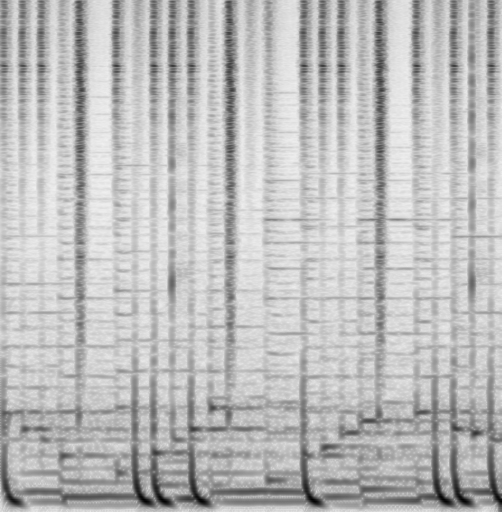

In [6]:
transformer.to_spectrogram("sample.wav", "sample.png")

## Prijenos stila

Ucitajmo spremljenje parametre i prenesimo stil zvuka. Ovisno o hiperparametrima moguce je dobiti drugacije rezultate. Uglavom se broj koraka inferencije ostavlja na 50 i mijenjaju se parametri `scale` i `strength`. `scale` određuje koliko ce se slika skalirati, dok `strength` određuje koliko ce se stil prenjeti.

In [7]:
model.text_transform.tve.load_state_dict(torch.load(f"./data/{dataset}-tve.pth", weights_only=True))

<All keys matched successfully>

100%|██████████| 41/41 [00:08<00:00,  4.63it/s]


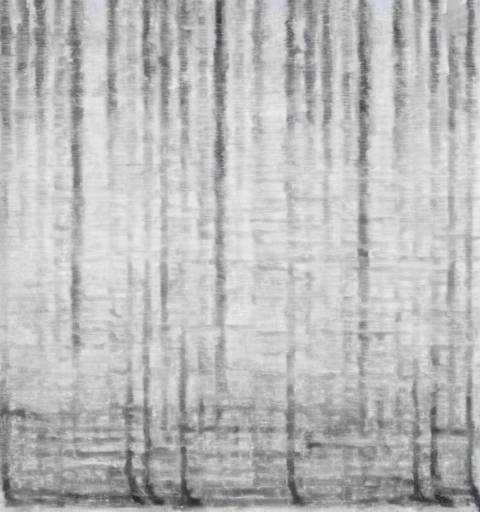

In [22]:
image = Image.open("sample.png")
#image = Image.open("./audios/timbre/cornet/data1.png")

image_stylized = model.transfer_style(
    image,
    "*",
    inference_steps=100,
    scale=3.5,
    strength=0.4,
    tve=True,
    bias_reduction=True
)

image_stylized.save("out_sample.png")
image_stylized

## Pretvori sliku u zvuk

U konacnici stiliziranu sliku MEL spektrograma pretvaramo nazad u zvuk

In [24]:
transformer.to_audio("out_sample.png", "out_sample.wav")

Pogledajmo i primjer stila koji smo koristili za treniranje.

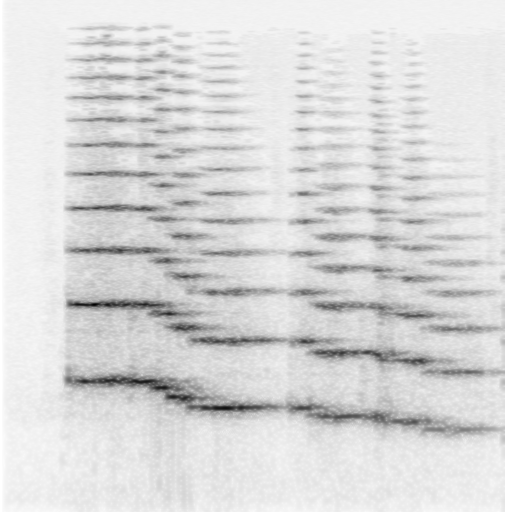

In [28]:
style_image = Image.open(f"./audios/timbre/{dataset}/{dataset}1.png")
style_image

In [29]:
transformer.to_audio(f"./audios/timbre/{dataset}/{dataset}1.png", f"./audios/timbre/{dataset}/{dataset}1.wav")

## Metrike

In [ ]:
content = ["sample.wav"]
stylized_content = ["out_sample.wav"]
style = ["./audios/cornet/cornet1.wav", "./audios/cornet/cornet2.wav", "./audios/cornet/cornet3.wav"]

print(f"Content preservation: {content_preservation(content, stylized_content)}")
print(f"Style fit: {style_fit(style, stylized_content)}")